In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load sample data (replace with your actual data loading)
data = pd.read_csv("Dataset/1000gear_dataset.csv", header=None)
# Assign column names
data.columns = ['Timestamp', 'CAN_ID', 'DLC', 'DATA0', 'DATA1',
                'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']

# Convert Flag column to numerical labels using label encoding
label_encoder = LabelEncoder()
data['Flag'] = label_encoder.fit_transform(data['Flag'])

data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Convert CAN ID and DLC to integer
data["CAN_ID"] = data["CAN_ID"].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
data["DLC"] = data["DLC"].astype(int)


In [27]:
# Convert DATA fields from hexadecimal strings to integers
def hex_to_int(x):
    if isinstance(x, str):
        try:
            return int(x, 16)
        except ValueError:
            return np.nan
    else:
        return x

# Convert DATA fields from hexadecimal strings to integers
for i in range(8):
    data[f"DATA{i}"] = data[f"DATA{i}"].apply(hex_to_int).astype(float)

# Assuming 'Flag' column represents the target variable
X = data.drop('Flag', axis=1)  # Features
y = data['Flag']  # Target variable

In [28]:


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop 'Timestamp' column from input features
X_train = X_train.drop('Timestamp', axis=1)
X_test = X_test.drop('Timestamp', axis=1)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

def SVC_Scan(x_train,y_train,x_test):
    # Initialize SVC with non-linear kernel
    svc_classifier = SVC(kernel='rbf')  # rbf stands for Radial Basis Function (non-linear)

    # Train the classifier
    svc_classifier.fit(x_train, y_train)
    # Predict on the test set
    
    return svc_classifier.predict(x_test)
    

def MLP_Scan(x_train,y_train,x_test):
    # Initialize MLP Classifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)  # Example parameters

    # Train the classifier
    mlp_classifier.fit(x_train, y_train)
    # Predict on the test set
    return mlp_classifier.predict(x_test)


#Run SVC ML
svc_y_predict= SVC_Scan(X_train_imputed,y_train,X_test_imputed);
svc_precision, svc_recall, svc_f1_score, _ = precision_recall_fscore_support(y_test, svc_y_predict, average='weighted')
print("SVC Precision:", svc_precision)
print("SVC Recall:", svc_recall)
print("SVC F1 Score:", svc_f1_score)


#Run MLP ML
mlp_y_predict=MLP_Scan(X_train_imputed,y_train,X_test_imputed);
mlp_precision, mlp_recall, mlp_f1_score, _ = precision_recall_fscore_support(y_test, mlp_y_predict, average='weighted')
print("MLP Precision:", mlp_precision)
print("MLP Recall:", mlp_recall)
print("NLP F1 Score:", mlp_f1_score)

SVC Precision: 0.9722877230935641
SVC Recall: 0.986046511627907
SVC F1 Score: 0.9791187843799357
MLP Precision: 0.9722877230935641
MLP Recall: 0.986046511627907
NLP F1 Score: 0.9791187843799357


c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:

# Calculate precision, recall, and F2 score
# precision = precision_score(y_test, y_pred, average='micro')
# recall = recall_score(y_test, y_pred, average='micro')
# f2_score = fbeta_score(y_test, y_pred, beta=2, average='micro')
# Convert class labels to strings
classes = [str(cls) for cls in label_encoder.classes_]




In [33]:


# Define the models and their corresponding metrics
models = ['SVC', 'MLP']
precision = [svc_precision, mlp_precision]
recall = [svc_recall, mlp_recall]
f1_score = [svc_f1_score, mlp_f1_score]
# support = [0.985408232, 1, 0.95, 0.92]

# Define the metrics to plot
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1_score]
value.col
values

[[0.9722877230935641, 0.9722877230935641],
 [0.986046511627907, 0.986046511627907],
 [0.9791187843799357, 0.9791187843799357]]

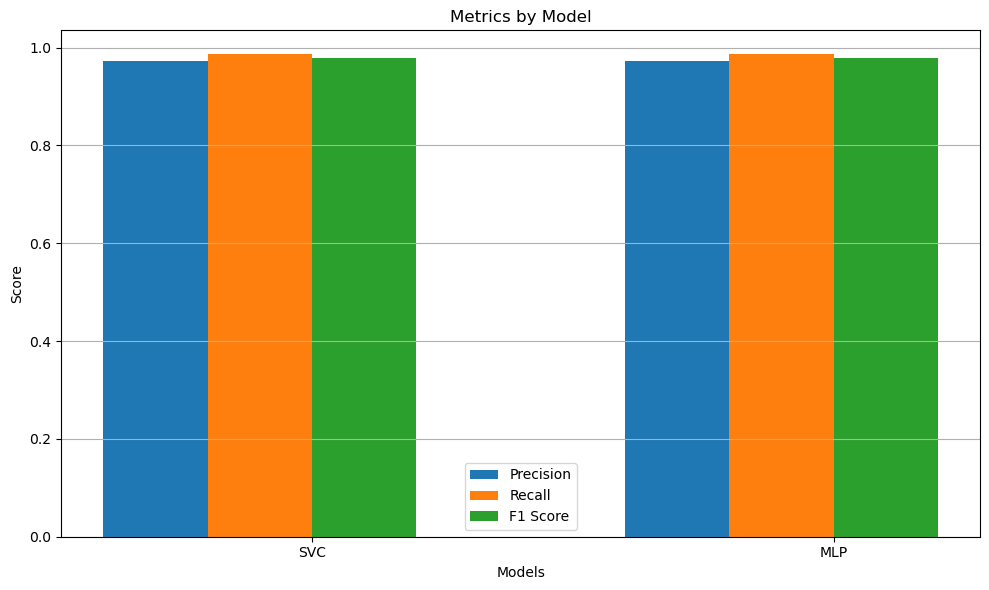

In [32]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot bars for each metric and model
bar_width = 0.2
index = np.arange(len(models))

for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, values[i], bar_width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Metrics by Model')
plt.xticks(index + bar_width * 1.5, models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
